In [32]:
import sys

sys.path.insert(0,'C:/Users/JeanBV/Documents/TFLearn_2/age-gender-estimation')

# cutFace algo

In [33]:
import cv2
import sys
import os
import numpy as np

#give grayscale image and 2D height and width of output and a facecascade
def cutFace(img,width,height,casc, database):

    try:
        if(database == 'MUG'):
            minSizeX = 100
            minSizeY = 100
        else:
            minSizeX = 100
            minSizeY = 100
        # Detect faces in the image
        faces = casc.detectMultiScale(
            img,
            scaleFactor=1.1,
            minNeighbors=5,
            minSize=(minSizeX, minSizeY),
            flags = cv2.CASCADE_SCALE_IMAGE
        )
        if(len(faces)!=0):
            for (x, y, w, h) in faces:
                if w > h :
                    he = w//2
                    wi = w//2
                else :
                    he = h//2
                    wi = h//2

                x_m = (x+w//2)
                y_m = (y+h//2)
                
                cut_image = img[y_m-he:y_m+he,x_m-wi:x_m+wi]
                cut_image = cv2.resize(cut_image,(width,height), interpolation = cv2.INTER_AREA)
        
        return cut_image

    except Exception as e:
        print(e)
   

# Alternative cutFace algo

In [34]:
# import cv2
# import os

# def cutFace(img,width,height, cascade, database):

#     try:
#         minisize = (img.shape[1],img.shape[0])
#         miniframe = cv2.resize(img, minisize)

#         faces = cascade.detectMultiScale(miniframe)
#         if(database == 'MMI'):
#             if(len(faces == 0)):
#                 img = np.rot90(img, k = 3)
#         for f in faces:
#             x, y, w, h = [ v for v in f ]
#             cv2.rectangle(img, (x,y), (x+w,y+h), (255,255,255))

#             sub_face = img[y:y+h, x:x+w]
#             sub_face = cv2.resize(sub_face,(width,height), interpolation = cv2.INTER_AREA)
#         if(len(faces)>=2):
#             cv2.imshow("frame", sub_face)
#             cv2.waitKey()
#         return sub_face
#     except Exception as e:
#         print(e)



# imports

In [35]:
from xml.dom import minidom
from glob import glob
import xml.etree.ElementTree
from lxml import etree
import os
import cv2

# get datapaths

In [36]:
data_path_CASPEAL = "C:/Users/JeanBV/Documents/databases/CAS_PEAL/CAS-PEAL-R1"
data_path_JAFFE = "C:/Users/JeanBV/Documents/databases/JAFFE_frames"
data_path_MUG = "C:/Users/JeanBV/Documents/databases/MUG/"
data_path_MMI = "C:/Users/JeanBV/Documents/databases/MMI"
data_path_CKP = "C:/Users/JeanBV/Documents/databases/CK+"

# get frames from videos with starting to ending frame

In [37]:
# def get_frames_from_vid(path):
#     cap = cv2.VideoCapture(path) #video_name is the video being called
#     cap.set(1, frame_no); # Where frame_no is the frame you want
#     ret, frame = cap.read() # Read the frame
#     cv2.imwrite("frames/"+path.split("\\")[9].split(".")[0]+".jpg", frame)     # save frame as JPEG file

In [38]:
def get_frames_from_vid(path,subject, start, end):
#     frame_dir= "Frame"
    subject_dir = subject
    list_of_frames = []
    
    #Not used right now
    
#     if not os.path.exists(frame_dir):
#         os.makedirs(frame_dir)
#     current_directory = os.path.abspath(frame_dir)
#     subject_dir = os.path.join(current_directory, subject_dir)
#     if not os.path.exists(subject_dir):
#         os.makedirs(subject_dir) 
        
    cap = cv2.VideoCapture(path) #video_name is the video being called
    
    cap.set(1,start); # Where frame_no is the frame you want
    ret, frame = cap.read() # Read the frame
    count = start
    while count <= end:
        list_of_frames.append(frame)
#       cv2.imwrite("Frame/"+subject+"/"+subject+"%d.jpg" % count, frame)     # save frame as JPEG file      
        ret,frame = cap.read()
        count += 1
    return list_of_frames

In [109]:
def input_MMI_database(X_data, Y_data, X_subID, N, A, D, H, Sa, Su, F, printData = 0):
    #subject counter   
    sub = 0
    lastSub = 0
    subjectID = 0
    i = 0
    dimMap = {}
    list_emotions=[]
    #intialize database path
    data_path = data_path_MMI
    #change directory to where the dB is situated
    os.chdir(data_path)
    label_expression = glob('./Sessions/*/*')
    amount_of_emotion = 0
    length_neutral_frames = 0
    length_all_frames = 0
    x_neutral = []
    x_emotion = []
    # print(os.getcwd())

    for file in label_expression:

        if(file.endswith('.avi')):
            xml_file = "."+file.split(".",-1)[1]+'.xml'
            myroot = xml.etree.ElementTree.parse(xml_file).getroot()
            for line in myroot.findall('Metatag'):
                if(line.attrib['Name'] == 'Emotion'):
                    #Extracting emotion
                    emotion_label = int(line.attrib['Value'])

            #Getting video
            video_path = os.path.abspath(file)

            #Get unique subject
            subjectID = video_path.split("\\")[-1].split(".")[0].split("-")[0]
            if subjectID != lastSub:
                sub = sub + 1
            lastSub = subjectID
            
            IDNumber = int(subjectID[1:])

            cap = cv2.VideoCapture(video_path)
            video_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            get_middle = int(video_length/2)

            lower_bound = get_middle - round(video_length/8)
            upper_bound = get_middle + round(video_length/8)

            #Get frames for emotions
            frames = get_frames_from_vid(video_path, subjectID, lower_bound, upper_bound)
            
            
            #Get neutral frames
            #First 5%
            frames_neutral_first_5 = get_frames_from_vid(video_path, subjectID, 0, int(video_length*0.015))
            #Last 5%
            frames_neutral_last_5 = get_frames_from_vid(video_path, subjectID, int(video_length*0.985), video_length)

            neutral_frames = frames_neutral_first_5 + frames_neutral_last_5
            
            X_data_before = len(X_data)
            #Neutral
            for frame in neutral_frames:
                if(frame is not None):
                    x = int(frame.shape[1])
                    if(subjectID == 'S001') or (subjectID == 'S002') or (subjectID == 'S017') :
                        sliced_image = frame[:, int(x/2):, :]
                    elif(subjectID == 'S003') or (subjectID == 'S005') or (subjectID == 'S006') or (subjectID == 'S015')or (subjectID == 'S016'):
                        sliced_image = frame[:, 0:int(x/2), :]
                    elif(subjectID == 'S021'):
                        continue
                    else:
                        sliced_image = frame
                    sliced_image = cv2.cvtColor(sliced_image, cv2.COLOR_BGR2GRAY)
                    
                    if(IDNumber > 21):
                        sliced_image = np.rot90(sliced_image, k = 3)
                        
                    X_data.append(sliced_image)
                    
            X_data_now_neutr = len(X_data)
                                     
            #Neutral
            #Get amount of neutral emotions to be added
            amount_of_neutral = X_data_now_neutr - X_data_before
            data_shape = np.zeros(amount_of_neutral).shape
            #Get Y_data
            #Neutral is characterized as a zero.
            Y_data_neutral = np.full(amount_of_neutral, 2) 
            #Get X_subID data
            X_subID_neutral = np.full(Y_data_neutral.shape, subjectID)
            i = i + amount_of_neutral

            #Store emotion label and subjectID in the corresponding lists
            Y_data.extend(Y_data_neutral)
            X_subID.extend(X_subID_neutral)

            N = N + amount_of_neutral
                
            length_x_neutral = len(X_data)
            #Emotions
            
            #These frames all have the same emotional label. They come from the same video. So it is safe to generalize all the emotions.
            for frame in frames:
                if(frame is not None) and (emotion_label >=0) and (emotion_label <=7):
                    x = int(frame.shape[1])
                    if(subjectID == 'S001') or (subjectID == 'S002') or (subjectID == 'S017') :
                        sliced_image = frame[:, int(x/2):, :]
                    elif(subjectID == 'S003') or (subjectID == 'S005') or (subjectID == 'S006') or (subjectID == 'S015')or (subjectID == 'S016'):
                        sliced_image = frame[:, 0:int(x/2), :]
                    elif(subjectID == 'S021'):
                        continue
                    else:
                        sliced_image = frame
                        
                    #Change to gray image
                    sliced_image = cv2.cvtColor(sliced_image, cv2.COLOR_BGR2GRAY)
                    if(IDNumber > 21):
                        sliced_image = np.rot90(sliced_image, k = 3)
                    X_data.append(sliced_image)
                    
            X_data_now_emotion = len(X_data)
            
            #Get amount of same emotion to be added
            amount_of_emotion = X_data_now_emotion - X_data_now_neutr

            if(emotion_label >=0) and (emotion_label <=7):
                #Mapping emotions to emotion values
                if(emotion_label == 1):
                    emotion_label_add = 1
                    emotion = 'Anger'
                    A = A + amount_of_emotion
                elif(emotion_label == 2):
                    emotion_label_add = 3
                    emotion = 'Disgust'
                    D = D + amount_of_emotion
                elif(emotion_label == 3):
                    emotion_label_add = 4
                    emotion = 'Fear '
                    F = F + amount_of_emotion
                elif(emotion_label == 4):
                    emotion_label_add = 5
                    emotion = 'Happy'
                    H = H + amount_of_emotion
                elif(emotion_label == 5):
                    emotion_label_add = 6
                    emotion = 'Saddness'
                    Sa = Sa + amount_of_emotion
                elif(emotion_label == 6):
                    emotion_label_add = 7
                    emotion = 'Surprise'
                    Su = Su + amount_of_emotion

                #Get np array size / shape
                data_shape = np.zeros(amount_of_emotion).shape
                #Get Y_data
                Y_data_emotion = np.full(data_shape, emotion_label_add)
                #Get X_subID data
                X_subID_emotion = np.full(data_shape, subjectID)
                i = i + amount_of_emotion
                Y_data.extend(Y_data_emotion)
                X_subID.extend(X_subID_emotion)

    return X_data, Y_data, X_subID, sub, i, N, A, D, H, F, Sa, Su

In [110]:
# def input_MMI_database(X_data, Y_data, X_subID, N, A, D, H, Sa, Su, F, printData = 0):
#     #subject counter   
#     sub = 0
#     lastSub = 0
#     subjectID = 0
#     i = 0
#     dimMap = {}
#     list_emotions=[]
#     #intialize database path
#     data_path = data_path_MMI
#     emotionNr = 0
#     #change directory to where the dB is situated
#     os.chdir(data_path)
#     label_expression = glob('./Sessions/*/*')

#     # print(os.getcwd())

#     for file in label_expression[0:50]:

#         if(file.endswith('.avi')):
#             xml_file = "."+file.split(".",-1)[1]+'.xml'
#             myroot = xml.etree.ElementTree.parse(xml_file).getroot()
#             for line in myroot.findall('Metatag'):
#                 if(line.attrib['Name'] == 'Emotion'):
#                     #Extracting emotion
#                     emotionNr = line.attrib['Value']

#             #Getting video
#             video_path = os.path.abspath(file)

#             #Get unique subject
#             subjectID = video_path.split("\\")[-1].split(".")[0].split("-")[0]
#             if subjectID != lastSub:
#                 sub = sub + 1
#             lastSub = subjectID

#             cap = cv2.VideoCapture(video_path)
#             video_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
#             get_middle = int(video_length/2)

#             lower_bound = get_middle - round(video_length/8)
#             upper_bound = get_middle + round(video_length/8)

#             #Get frames for emotions
#             frames = get_frames_from_vid(video_path, subjectID, lower_bound, upper_bound)
            
# #             #Get frames for neutral emotions. We expect the first 5% and last 5% of the videos to be of a neutral emotion.
# #             #First 5%
# #             frames_neutral_first_5 = get_frames_from_vid(video_path, subjectID, 0, int(videolength*0.05))
# #             #Last 5%
# #             frames_neutral_last_5 = get_frames_from_vid(video_path, subjectID, int(videolength*0.95), videolength)

# #             neutral_frames = frames_neutral_first_5 + frames_neutral_last_5
# #             X_data_neutral = frames_neutral_first_5 + frames_neutral_last_5
# #             Y_data_neutral = np.zeros(len(X_data_neutral))
# #             X_subID_neutral = np.full(Y_data_neutral.shape, subjectID)

# #             for frame in neutral_frames:
# #                 if(frame is not None):
# #                     x = int(frame.shape[1])
# #                     if(subjectID == 'S001') or (subjectID == 'S002'):
# #                         sliced_image = frame[:, int(x/2):, :]
# #                     elif(subjectID == 'S003') or (subjectID == 'S005') or (subjectID == 'S006') or (subjectID == 'S0015'):
# #                         sliced_image = frame[:, 0:int(x/2), :]
# #                     elif(subjectID == 'S021'):
# #                         continue
# #                     else:
# #                         sliced_image = frame
                

#                     x = int(frame.shape[1])
#                     if(subjectID == 'S001') or (subjectID == 'S002'):
#                         sliced_image = frame[:, int(x/2):, :]
#                     elif(subjectID == 'S003') or (subjectID == 'S005') or (subjectID == 'S006') or (subjectID == 'S0015'):
#                         sliced_image = frame[:, 0:int(x/2), :]
#                     elif(subjectID == 'S021'):
#                         continue
#                     else:
#                         sliced_image = frame

#                     sliced_image = cv2.cvtColor(sliced_image, cv2.COLOR_BGR2GRAY)
#                     emotionNr = int(emotionNr)
#                     original_emotion = emotionNr

#                     if(int(emotionNr) >=0) and (int(emotionNr) <=7):
                        
#                         #Mapping emotions to emotion values
#                         if(int(emotionNr) == 1):
#                             emotionNr = 1
#                             emotion = 'Anger'
#                             A = A + 1
#                         elif(emotionNr == 2):
#                             emotionNr = 3
#                             emotion = 'Disgust'
#                             D = D + 1
#                         elif(emotionNr == 3):
#                             emotionNr = 4
#                             emotion = 'Fear '
#                             F = F + 1
#                         elif(emotionNr == 4):
#                             emotionNr = 5
#                             emotion = 'Happy'
#                             H = H + 1
#                         elif(emotionNr == 5):
#                             emotionNr = 6
#                             emotion = 'Saddness'
#                             Sa = Sa + 1
#                         elif(emotionNr == 6):
#                             emotionNr = 7
#                             emotion = 'Surprise'
#                             Su = Su + 1

#                         #Store image and emotion label in the X_data and Y_data lists
#                         X_data.append(neutr_X)
#                         X_data.append(sliced_image)
#                         Y_data.append(emotionNr)
#                         X_subID.append(subjectID)
#                         i = i+1

#                         #load in original emotion again
#                         emotionNr = original_emotion

#     return X_data, Y_data, X_subID, sub, i, N, A, D, H, F, Sa, Su

<h3> CKP database </h3>

In [111]:
def input_CKP_database(X_data, Y_data, X_subID, N, A, D, H, Sa, Su, F, C, printData = 0):
    #stores the current working directory path to restore at the end and goes to the given database path
    curr_path = os.getcwd()
    #subject counter   
    sub = 0
    lastSub = 0
    subjectID = 0
    i = 0
    dimMap = {}
    list_emotions=[]
    #intialize database path
    data_path = data_path_CKP
    emotionNr = 0
    #change directory to where the dB is situated
    os.chdir(data_path)
    
    label_list = glob('./Emotion/*/*/*.txt')

    X_data = [] # list of input data = climax images of emotions
    Y_data = [] # list of output data = emotion expressed in image

    X_subID = [] # list with subject Id of each X_data element 

    i = 0 #count of total amount of instances
    
    #subject counter
    sub = 0
    lastSub = 0
    subjectID = 0

    dimMap = {}


    #iterate through the list of label files, open corresponding images
    for fn in label_list[0:500]:
        str = './cohn-kanade-images'+ fn[9:-12] + '.png'
        image = cv2.imread(str)
        img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # emotion label
        file = open(fn,'r')
        fileTxt = file.read()

        emotionNr = int(fileTxt[3:4])
        #print("emotion:", emotionNr)
        file.close()

        #determine the subject
        subjectID = fn[11:14]
        if subjectID != lastSub :
            sub = sub + 1
        lastSub = subjectID 

        #determine the emotion of the image
        if(emotionNr == 0):
            emotion = 'Neutral'
            N = N + 1
        elif(emotionNr == 1):
            emotion = 'Anger'
            A = A + 1
        elif(emotionNr == 2):
            emotion = 'Contempt'
            C = C + 1
        elif(emotionNr == 3):
            emotion = 'Disgust'
            D = D + 1
        elif(emotionNr == 4):
            emotion = 'Fear '
            F = F + 1
        elif(emotionNr == 5):
            emotion = 'Happy'
            H = H + 1
        elif(emotionNr == 6):
            emotion = 'Saddness'
            Sa = Sa + 1
        else:
            emotion = 'Surprise'
            Su = Su + 1

        #Store image and emotion label in the X_data and Y_data lists
        X_data.append(img)
        Y_data.append(emotionNr)
        X_subID.append(subjectID)
        i = i+1

    return X_data, Y_data, X_subID, sub, i, N, A, D, H, F, Sa, Su, C

<h3> MUG database </h3>

In [112]:
def input_MUG_database(X_data, Y_data, X_subID, N, A, D, H, Sa, Su, F, printData = 0):
    #subject counter   
    sub = 0
    lastSub = 0
    subjectID = 0
    i = 0
    dimMap = {}
    
    #intialize database path
    data_path = data_path_MUG

    #change directory to where the dB is situated
    os.chdir(data_path)
    
    #The different emotions are stored in different folders accross the directory
    label_expression = glob('./*/*/*/')
    label_session_expression = glob('./*/session*/*/*/')
    

    for image in label_session_expression[0:5]:
        
        #Get amount of images per emotion
        amount_of_images = len(os.listdir(image))
        
        #Get emotion label
        
        emotion_label = image.split("\\")[3]
        if(emotion_label != 'mixed'):
            
            #Get middle image
            middle_image = round(amount_of_images/2)    
            
            #Create bounds
            lower_bound = middle_image - round(amount_of_images/8)
            upper_bound = middle_image + round(amount_of_images/8)
            
            #Get list of images
            image_list =(os.listdir(image))
            
            #Bound the list of images
            image_list_bound = (image_list[lower_bound:upper_bound])
            for k in range(len(image_list_bound)):
                img_path = (os.path.abspath(image)+"\\"+image_list_bound[k])
                image_rd = cv2.imread(img_path)
                img = cv2.cvtColor(image_rd, cv2.COLOR_BGR2GRAY)

                 #Get emotion labels
                if(emotion_label == 'neutral'):
                    emotion_label_add = 2
                    emotion = 'Neutral'
                    N = N + 1
                elif(emotion_label == 'anger'):
                    emotion_label_add = 1
                    emotion = 'Anger'
                    A = A + 1
                elif(emotion_label == 'disgust'):
                    emotion_label_add = 3
                    emotion = 'Disgust'
                    D = D + 1
                elif(emotion_label == 'fear'):
                    emotion_label_add = 4
                    emotion = 'Fear '
                    F = F + 1
                elif(emotion_label == 'happiness'):
                    emotion_label_add = 5
                    emotion = 'Happy'
                    H = H + 1
                elif(emotion_label == 'sadness'):
                    emotion_label_add = 6
                    emotion = 'Saddness'
                    Sa = Sa + 1
                elif(emotion_label == 'surprise'):
                    emotion_label_add = 7
                    emotion = 'Surprise'
                    Su = Su + 1

                subjectID = img_path.split("\\")[6]
                if subjectID != lastSub :
                    sub = sub + 1
                lastSub = subjectID 

                # store image and emotion label in the X_data and Y_data lists
                X_data.append(img)               
                Y_data.append(emotion_label_add)
                X_subID.append(subjectID)
                i = i+1
                
    for image in label_expression[0:5]:

        #Get amount of images per emotion
        amount_of_images = len(os.listdir(image))
        
        #Get emotion label
        emotion_label = image.split("\\")[2]
        
        
        #Exclude mixed emotion
        if(emotion_label != 'mixed'):
            
            #Get the middle_image
            middle_image = round(amount_of_images/2)
            
            #Create bounds
            lower_bound = middle_image - round(amount_of_images/6)
            upper_bound = middle_image + round(amount_of_images/6)

            #Get list of images
            image_list = os.listdir(image)

            #Bound the list of images
            image_list_bound = (image_list[lower_bound:upper_bound])
            for k in range(len(image_list_bound)):
                img_path = (os.path.abspath(image)+"\\"+image_list_bound[k])
                image_rd = cv2.imread(img_path)
                img = cv2.cvtColor(image_rd, cv2.COLOR_BGR2GRAY)

                original_emotion = emotion_label
                if(emotion_label == 'neutral'):
                    emotion_label_add = 2
                    emotion = 'Neutral'
                    N = N + 1
                elif(emotion_label == 'anger'):
                    emotion_label_add = 1
                    emotion = 'Anger'
                    A = A + 1
                elif(emotion_label == 'disgust'):
                    emotion_label_add = 3
                    emotion = 'Disgust'
                    D = D + 1
                elif(emotion_label == 'fear'):
                    emotion_label_add = 4
                    emotion = 'Fear'
                    F = F + 1
                elif(emotion_label == 'happiness'):
                    emotion_label_add = 5
                    emotion = 'Happy'
                    H = H + 1
                elif(emotion_label == 'sadness'):
                    emotion_label_add = 6
                    emotion = 'Saddness'
                    Sa = Sa + 1
                elif(emotion_label == 'surprise'):
                    emotion_label_add = 7
                    emotion = 'Surprise'
                    Su = Su + 1

                #Get subject
                subjectID = img_path.split("\\")[6]
                if subjectID != lastSub :
                    sub = sub + 1
                lastSub = subjectID 

                # store image and emotion label in the X_data and Y_data lists
                X_data.append(img)
                Y_data.append(emotion_label_add)
                X_subID.append(subjectID)
                i = i+1
                
    return X_data, Y_data, X_subID, sub, i, N, A, D, H, F, Sa, Su



<h3> JAFFE database </h3>

In [113]:
def input_JAFFE_database(X_data, Y_data, X_subID, N, A, D, H, Sa, Su, F, printData = 0):

    #subject counter
    sub = 0
    lastSub = 0
    subjectID = 0
    i = 0
    dimMap = {}
    #intialize database path
    data_path = data_path_JAFFE

    #change directory to where the dB is situated
    os.chdir(data_path)
    print(os.path.abspath(data_path))

    #get the emotion expressions
    label_expression = glob('./*.tiff')
    for fn in label_expression:

        #get emotion
        emotion_label = fn.split(".")[2][0:2]

        #load image
        image = cv2.imread(fn)
        img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        if(emotion_label == 'NE'):
            emotion_label_add = 2
            emotion = 'Neutral'
            N = N + 1
        elif(emotion_label == 'AN'):
            emotion_label_add = 1
            emotion = 'Anger'
            A = A + 1
        elif(emotion_label == 'DI'):
            emotion_label_add = 3
            emotion = 'Disgust'
            D = D + 1
        elif(emotion_label == 'FE'):
            emotion_label_add =4
            emotion = 'Fear '
            F = F + 1
        elif(emotion_label == 'HA'):
            emotion_label_add =5
            emotion = 'Happy'
            H = H + 1
        elif(emotion_label == 'SA'):
            emotion_label_add =6
            emotion = 'Saddness'
            Sa = Sa + 1
        elif(emotion_label == 'SU'):
            emotion_label_add =7
            emotion = 'Surprise'
            Su = Su + 1

        #get subjectID
        subjectID = fn.split(".")[1][1:]
        if subjectID != lastSub:
            sub = sub + 1
        lastSub = subjectID

        #store image and emotion label in the X_data and Y_data lists
        X_data.append(img)
        Y_data.append(emotion_label_add)
        X_subID.append(subjectID)
        i = i+1
    return X_data, Y_data, X_subID, sub, i, N, A, D, H, F, Sa, Su

<h3> CASPEAL database </h3>

In [114]:
def input_CASPEAL_database(X_data, Y_data, X_subID, N, A, H, Su, printData = 0):

    #subject counter
    sub = 0
    lastSub = 0
    subjectID = 0
    i = 0
    dimMap = {}
    
    #intialize database path
    data_path = data_path_CASPEAL

    #change directory to where the dB is situated
    os.chdir(data_path)

    #get the emotion expressions
    label_expression = glob('./FRONTAL/Expression/*.tif')
    label_neutral = glob('./FRONTAL/Normal/*.tif')

    label_total = label_expression + label_neutral
    #remove unused emotions. This way we don't loop through unneeded emotions.
    for remove_image in label_total:
        if(remove_image.split("+")[2].split("_")[1][1] == "C") or (remove_image.split("+")[2].split("_")[1][1] == "O"):
            label_total.remove(remove_image)
            
    for fn in label_total:
        #Get emotion number
        emotion_label = fn.split("+")[2].split("_")[1][1]
        
        #Load the imae
        image = cv2.imread(fn)
        img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        #Get emotion labels
        if(emotion_label == 'N'):
            emotion_label_add = 2
            emotion = 'Neutral'
            N = N + 1
        elif(emotion_label == 'F'):
            emotion_label_add = 1
            emotion = 'Anger'
            A = A + 1
        elif(emotion_label == 'L'):
            emotion_label_add = 5
            emotion = 'Happy'
            H = H + 1
        elif(emotion_label == 'S'):
            emotion_label_add = 7
            emotion = 'Surprise'
            Su = Su + 1

        #Get subject
        subjectID = fn.split("\\")[1].split("_")[1]
        if subjectID != lastSub :
            sub = sub + 1
        lastSub = subjectID 

        # store image and emotion label in the X_data and Y_data lists
        X_data.append(img)
        Y_data.append(emotion_label_add)
        X_subID.append(subjectID)
        i = i+1

    return X_data, Y_data, X_subID, sub, i, N, A, H, Su

<h3> Load data algo </h3>

In [115]:
import numpy as np
import cv2
import scipy as sc
import matplotlib.pyplot as plt
from glob import glob 
import re
import os

import tflearn

def load_data(database): 
        
    #stores the current working directory path to restore at the end.
    curr_path = os.getcwd()
    
    #Initialization
    X_data = [] # list of input data = climax images of emotions
    Y_data = [] # list of output data = emotion expressed in image
    X_subID = [] # list with subject Id of each X_data element 

    i = 0 #count of total amount of instances

    #Count per emotion
    N = 0 # Neutral
    A = 0 # Anger
    C = 0 # Contempt
    D = 0 # Disgust
    F = 0 # Feard
    H = 0 # Happy
    Sa = 0# Saddness
    Su = 0# Surprise

    #Get X_data, Y_data, and other details of each of the databases
    #Since the data is differently distributed accross the different databases, seperate functions are created 
    if(database == "CASPEAL"):
        X_data, Y_data, X_subID, sub, i, N, A, H, Su = input_CASPEAL_database(X_data, Y_data, X_subID, N, A, H, Su)

    if(database == "MUG"):
        X_data, Y_data, X_subID, sub, i, N, A, D, H,F, Sa, Su = input_MUG_database(X_data, Y_data, X_subID, N, A, D, H, Sa, Su, F)

    if(database == "JAFFE"):
        X_data, Y_data, X_subID, sub, i, N, A, D, H, F, Sa, Su = input_JAFFE_database(X_data, Y_data, X_subID, N, A, D, H, Sa, Su, F)

    if(database == "MMI"):
        from time import time
        t0 = time()
        X_data, Y_data, X_subID, sub, i, N, A, D, H, F, Sa, Su = input_MMI_database(X_data, Y_data, X_subID, N, A, D, H, Sa, Su, F)
        t1 = time()
        print('function vers1 takes %f' %(t1-t0))

    if(database == "CKP"):
        X_data, Y_data, X_subID, sub, i, N, A, D, H, F, Sa, Su, C = input_CKP_database(X_data, Y_data, X_subID, N, A, D, H, Sa, Su, F, C)
        
    #show stattistics
    print("--------- Overal stattistics ---------  ")
    print("amount of Subjects  : %d" % sub)
    print("amount of Instances : %d" % i)
    print("code = 0 = Neutral    %d instances: %.2f"  % (N,((float(N)/i)*100)))
    print("code = 1 = Anger      %d instances: %.2f"  % (A,((float(A)/i)*100)))
    print("code = 2 = Contempt   %d instances: %.2f"  % (C,((float(C)/i)*100)))
    print("code = 3 = Disgust    %d instances: %.2f"  % (D,((float(D)/i)*100)))
    print("code = 4 = Fear       %d instances: %.2f"  % (F,((float(F)/i)*100)))
    print("code = 5 = Happy      %d instances: %.2f"  % (H,((float(H)/i)*100)))
    print("code = 6 = Saddness   %d instances: %.2f"  % (Sa,((float(Sa)/i)*100)))
    print("code = 7 = Surprise   %d instances: %.2f"  % (Su,((float(Su)/i)*100)))
    print("--------- dimensions ---------  ")

    print("--------- last elements in lists ---------  ")
    print("length X_data" + repr(len(X_data))) 
    print("length Y_data" + repr(len(Y_data))) 

    plt.figure('last image')
    plt.imshow(X_data[len(X_data)-1], cmap='gray')#, interpolation='nearest');
    plt.show()

    print("length Y_data " + repr(Y_data[len(Y_data)-1])) 
    print("image type " + repr(type(Y_data[len(Y_data)-1]))) 

    #Original path restored
    os.chdir(curr_path)

    return [X_data,Y_data,X_subID]  

# CREATE NPY

In [116]:
import copy
def load_formated_data(database, printData = 0, cascPath = "C:/Users/JeanBV/Documents/Thesis_Christiaan_Jean/Custom_Dexpression/haarcascade.xml"):

    data = load_data(database)
    print("test")
    #data[0] = X images
    #data[2] = Y emotion labels
    #data[3] = subject Ids
    print("data:", data)
    images = data[0]
    emotion_labels = data[1]
    emotion_labels_new = copy.deepcopy(emotion_labels)
    subjectID = copy.deepcopy(data[2])
    # cut faces from each images and resize (downsample) to input dimension
    X_gray = []
    X_test = []

    # Create the haar cascade
    faceCascade = cv2.CascadeClassifier(cascPath)

    
    for i in range(0,len(images)):
        cut_img = cutFace(images[i],224,224,faceCascade, database)
        #Be sure that cut_img is initialized
        if(cut_img is not None):
            X_gray = np.append(X_gray,cut_img)
        else:
            emotion_labels_new.remove(emotion_labels_new[i])
            subjectID.remove(subjectID[i])
    #Resize to 224x224 image for input of neural networkCKE
    X_gray = X_gray.reshape([-1,224,224,1])

    # reformprint(at the emotionlabels to create a vector of 7 zeros only one of these elements is set to 1 indicating the emotion label
    labels = []

    for lab in emotion_labels_new:
        inst = np.zeros(7)
        inst[lab-1] = 1
        #print (inst)
        labels = np.append(labels,inst)

    print("size Y 2: " + repr(labels.shape))

    labels = labels.reshape([-1,7])

    print("size labels flatten: " + repr(len(labels)))
    print("size labels shape: " + repr(labels.shape))
    print("type labels: " + repr(type(labels)))

    outputData = [X_gray,labels,subjectID]

    print("ouputData", outputData)
    return outputData


    #data = load_formated_database(dataPath,0)

def create_formated_data(database, printData = 0, cascPath = "C:/Users/JeanBV/Documents/Thesis_Christiaan_Jean/Custom_Dexpression/haarcascade.xml" , databasePath = 'C:/Users/JeanBV/Documents/Thesis_Christiaan_Jean/Custom_Dexpression/'):
   
    data = load_formated_data(database, printData, cascPath)
    
    os.chdir(databasePath)
    print("making dB")
  
    #Creating directories to save the npy files of the database
    database = database
    npy_folder = "output_npy"
    if not os.path.exists(npy_folder):
        os.makedirs(npy_folder)

    current_directory = os.path.abspath(npy_folder)
    subject_dir = os.path.join(current_directory, database) #The rule to get the folder INSIDE the folder
    if not os.path.exists(subject_dir):
        os.makedirs(subject_dir)
   
    print(os.getcwd())
    np.save(subject_dir+"\\"+database+'_X.npy',data[0])
    np.save(subject_dir+"\\"+database+'_Y.npy',data[1])
    np.save(subject_dir+"\\"+database+'_subjectIDs.npy',data[2])



function vers1 takes 355.524335
--------- Overal stattistics ---------  
amount of Subjects  : 33
amount of Instances : 5797
code = 0 = Neutral    963 instances: 16.61
code = 1 = Anger      753 instances: 12.99
code = 2 = Contempt   0 instances: 0.00
code = 3 = Disgust    664 instances: 11.45
code = 4 = Fear       626 instances: 10.80
code = 5 = Happy      1110 instances: 19.15
code = 6 = Saddness   888 instances: 15.32
code = 7 = Surprise   793 instances: 13.68
--------- dimensions ---------  
--------- last elements in lists ---------  
length X_data5797
length Y_data5797


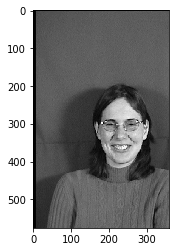

length Y_data 2
image type <class 'numpy.int32'>
test
data: [[array([[ 8,  8,  8, ...,  7,  5,  5],
       [ 9,  9,  9, ...,  7,  6,  6],
       [85, 84, 82, ..., 59, 60, 61],
       ...,
       [17, 17, 17, ..., 16, 17, 17],
       [19, 17, 15, ..., 18, 15,  9],
       [16, 18, 16, ..., 13, 11, 12]], dtype=uint8), array([[ 9,  9,  9, ...,  6,  5,  5],
       [ 9,  9,  9, ...,  5,  4,  4],
       [85, 84, 84, ..., 63, 63, 63],
       ...,
       [19, 16, 15, ..., 19, 18, 10],
       [13, 13, 17, ..., 18, 13, 11],
       [18, 17, 15, ..., 13, 12, 17]], dtype=uint8), array([[10, 10, 10, ...,  8,  5,  5],
       [10, 10, 10, ...,  7,  4,  4],
       [82, 90, 94, ..., 61, 60, 59],
       ...,
       [17, 12, 12, ..., 13, 13, 13],
       [21, 16, 17, ..., 11, 13, 20],
       [14, 14, 19, ..., 12, 19, 18]], dtype=uint8), array([[ 9,  9,  9, ...,  7,  4,  4],
       [ 9,  9, 10, ...,  6,  4,  5],
       [85, 85, 85, ..., 61, 60, 59],
       ...,
       [12, 14, 16, ..., 15, 16, 15],
       [1

In [ ]:
create_formated_data('MMI')

## Loading numpy file

In [8]:
import numpy as np

In [98]:
os.chdir('C:/Users/JeanBV/Documents/Thesis_Christiaan_Jean/Custom_Dexpression')

In [99]:
MMI = [np.load('./output_npy/MMI/MMI_X.npy'), np.load('./output_npy/MMI/MMI_Y.npy'), np.load('./output_npy/MMI/MMI_subjectIDs.npy')]
# CASPEAL = [np.load('./output_npy/CASPEAL/CASPEAL_X.npy'), np.load('./output_npy/CASPEAL/CASPEAL_Y.npy'), np.load('./output_npy/CASPEAL/CASPEAL_subjectIDs.npy')]
# JAFFE = [np.load('./output_npy/JAFFE/JAFFE_X.npy'), np.load('./output_npy/JAFFE/JAFFE_Y.npy'), np.load('./output_npy/JAFFE/JAFFE_subjectIDs.npy')]

## Testing

### Creating emotional labels

In [100]:
angry = np.array([1.0,0.0,0.0,0.0,0.0,0.0,0.0])
neutral = np.array([0.0,1.0,0.0,0.0,0.0,0.0,0.0])
disgust = np.array([0.0,0.0,1.0,0.0,0.0,0.0,0.0])
fear = np.array([0.0,0.0,0.0,1.0,0.0,0.0,0.0])
happy = np.array([0.0,0.0,0.0,0.0,1.0,0.0,0.0])
sad = np.array([0.0,0.0,0.0,0.0,0.0,1.0,0.0])
surprise = np.array([0.0,0.0,0.0,0.0,0.0,0.0,1.0])

In [101]:
def create_emotion_list(database):
    emotion_list = []
    for i in range(len(database[1])):
        if(np.array_equal(angry,database[1][i])):
            emotion = 'angry'
            emotion_list.append(emotion)
        elif(np.array_equal(neutral,database[1][i])):
            emotion = 'neutral'
            emotion_list.append(emotion)
        elif(np.array_equal(disgust,database[1][i])):
            emotion = 'disgust'
            emotion_list.append(emotion)
        elif(np.array_equal(fear,database[1][i])):
            emotion = 'fear'
            emotion_list.append(emotion)
        elif(np.array_equal(happy,database[1][i])):
            emotion = 'happy'
            emotion_list.append(emotion)
        elif(np.array_equal(sad,database[1][i])):
            emotion = 'sad'
            emotion_list.append(emotion)
        elif(np.array_equal(surprise,database[1][i])):
            emotion = 'surprise'
            emotion_list.append(emotion)
    return emotion_list

### Verifying emotion vs face

In [102]:
MMI_emotion = create_emotion_list(MMI)

### Printing emotion vs face imshow

In [103]:
def print_database_pics(database, emotions):
    for i in range(len(database[0])):
        cv2.imshow("Emotion: "+ emotions[i], database[0][i].astype('uint8'))
        cv2.waitKey(0)
        cv2.destroyAllWindows()

In [104]:
print_database_pics(MMI, MMI_emotion)

KeyboardInterrupt: 

### Storing neutral faces and corresponding subject IDs

In [105]:
def get_neutral_faces(database, emotions):
    neutral_faces = []
    subject_ID = []
    for i in range(len(database[0])):
        if(emotions[i] == 'neutral'):
            neutral_faces.append(database[0][i])
            subject_ID.append(database[2][i])
    return neutral_faces, subject_ID

In [106]:
#Index 0: pics, index 1: subject IDs
neutral_MMI = get_neutral_faces(MMI, MMI_emotion)

### Checking neutral faces and subject IDs

In [107]:
def print_neutral_faces(neutral_database):
    for i in range(len(neutral_database[0])):
        cv2.imshow(neutral_database[1][i], neutral_database[0][i].astype('uint8'))
        cv2.waitKey()
        cv2.destroyAllWindows()

In [108]:
print_neutral_faces(neutral_MMI)

KeyboardInterrupt: 

In [ ]:
MMI_pics = neutral_MMI

MMI_pics

In [ ]:
import os
import cv2
import dlib
import numpy as np
import argparse
from contextlib import contextmanager
from wide_resnet import WideResNet
from keras.utils.data_utils import get_file

In [ ]:
import os
import cv2
import dlib
import numpy as np
import argparse
from contextlib import contextmanager
from wide_resnet import WideResNet
from keras.utils.data_utils import get_file

pretrained_model = "https://github.com/yu4u/age-gender-estimation/releases/download/v0.5/weights.18-4.06.hdf5"
modhash = '89f56a39a78454e96379348bddd78c0d'

#Loading in CAS_PEAL dB first
ages_arr=[]
# CAS_PEAL_img = CAS_PEAL_filepaths_subj()
# ages_arr = CAS_PEAL_img

img_arr = []
def draw_label(image, point, label, font=cv2.FONT_HERSHEY_SIMPLEX,
               font_scale=1, thickness=2):
    size = cv2.getTextSize(label, font, font_scale, thickness)[0]
    x, y = point
    cv2.rectangle(image, (x, y - size[1]), (x + size[0], y), (255, 0, 0), cv2.FILLED)
    cv2.putText(image, label, point, font, font_scale, (255, 255, 255), thickness)


def load_images(depth = 16, k = 8, weight_file = None):
    if not weight_file:
        weight_file = get_file("weights.18-4.06.hdf5", pretrained_model, cache_subdir="pretrained_models",
                               file_hash=modhash, cache_dir=os.path.dirname(os.path.abspath('C:/Users/JeanBV/Documents/TFLearn_2/age-gender-estimation/pretrained_models')))
    
    # for face detection
    detector = dlib.get_frontal_face_detector()

    # load model and weights
    img_size = 64
    model = WideResNet(img_size, depth=depth, k=k)()
    model.load_weights(weight_file)
    
    MMI_pics = neutral_MMI

#     for pic in MUG_pics[0:20]:
    for i in range(len(MMI_pics[0])):
        classified_MMI_pics = main("MMI",MMI_pics[0][i], MMI_pics[1][i], detector, model, img_size)
#     for pic in DISFA_pics:
#         array_DISFA_pics = main("DISFA", pic, detector, model, img_size)
#     for pic in MMI_pics:
#         array_MNIST_pics = main("MMI", pic, detector, model, img_size)
#     for pic in CKE_pics:
#         array_CKE_pics = main("CKE", pic, detector, model, img_size)
#     for pic in JAFFE_pics:
#         array_JAFFE_pics = main("JAFFE", pic, detector, model, img_size)
   
    return classified_MMI_pics
def main(src, img, subjectID, detector, model, img_size):
    
    #Get BGR in order for the detector to work.
    input_img = cv2.cvtColor(img.astype('uint8'), cv2.COLOR_GRAY2BGR)
    cut_image = cv2.resize(input_img, (64, 64), interpolation = cv2.INTER_AREA)
    cut_image = np.expand_dims(cut_image, axis=0)
#     detected = detector(input_img, 1)
#     img_h, img_w, _ = np.shape(input_img)
#     faces = np.empty((len(detected), img_size, img_size, 3))
    
#     print(faces.shape)
    # predict ages and genders of the detected faces
    results = model.predict(cut_image)
    predicted_genders = results[0]
    ages = np.arange(0, 101).reshape(101, 1)
    predicted_ages = results[1].dot(ages).flatten()
        
#     cv2.imshow("image", cut_image)
#     cv2.waitKey()
#     cv2.destroyAllWindows()
    print("genders: ", predicted_genders)
    print("ages: ", predicted_ages[0])
    # draw results
    if predicted_genders[0][0] > 0.5:
        gender = "F"
    else:
        gender = "M"
    
    ages_arr.append([src, subjectID, int(predicted_ages[0]), gender])
    return ages_arr


## Classifcation

In [20]:
#Load data
MMI_data = load_images()

genders:  [[0.50169104 0.49830902]]
ages:  19.152306495113407
genders:  [[0.5485407  0.45145935]]
ages:  19.386912064841454
genders:  [[0.49348637 0.5065136 ]]
ages:  19.100650285718075
genders:  [[0.57378 0.42622]]
ages:  18.966736360675895
genders:  [[0.57378 0.42622]]
ages:  18.966736360675895
genders:  [[0.66035014 0.3396499 ]]
ages:  20.079180452339642
genders:  [[0.57930094 0.420699  ]]
ages:  20.035779278208793
genders:  [[0.54641396 0.4535861 ]]
ages:  18.01555088121131
genders:  [[0.6303238  0.36967617]]
ages:  19.26384300419977
genders:  [[0.65537083 0.34462917]]
ages:  20.147758339885513
genders:  [[0.5682618 0.4317382]]
ages:  19.011613185935857
genders:  [[0.5184017  0.48159835]]
ages:  19.948973841756015
genders:  [[0.5682618 0.4317382]]
ages:  19.011613185935857
genders:  [[0.5184017  0.48159835]]
ages:  19.948973841756015
genders:  [[0.26406845 0.7359316 ]]
ages:  21.09099426137618
genders:  [[0.39210874 0.60789126]]
ages:  21.82876355935514
genders:  [[0.77241576 0.227

genders:  [[0.7322079  0.26779208]]
ages:  18.4511129587263
genders:  [[0.76299626 0.23700373]]
ages:  20.046684040284163
genders:  [[0.75650686 0.2434931 ]]
ages:  20.128911842763046
genders:  [[0.35503662 0.6449634 ]]
ages:  26.257370828825515
genders:  [[0.48545977 0.51454026]]
ages:  26.283461233811977
genders:  [[0.31453627 0.6854637 ]]
ages:  26.2419159048477
genders:  [[0.61054796 0.38945198]]
ages:  28.668576826930803
genders:  [[0.5467871  0.45321295]]
ages:  28.271804428073665
genders:  [[0.75603825 0.24396178]]
ages:  27.60499101980895


In [21]:
import pandas as pd

In [22]:
#Create dataframe
classification_df = pd.DataFrame(MMI_data, columns = ['dB', 'ID', 'Age', 'Gender'])

In [24]:
### Get median age and gender ratio

#Expects dataframe from the database-data
def get_median_age_and_gender(dataframe):
    age_and_gender = []
    for unique_ID in unique_IDs:
        database = dataframe[dataframe['ID'] == unique_ID]['dB'].iloc[0]
        median_age = dataframe[dataframe['ID'] == unique_ID]['Age'].median()
        female_count = dataframe[dataframe['ID'] == unique_ID][dataframe['Gender']=='F'].count()[0]
        male_count = dataframe[dataframe['ID'] == unique_ID][dataframe['Gender']=='M'].count()[0]
        if(male_count == 0.0):
            male_count = 1.0
        ratio = female_count/male_count
        if(ratio <=1.0):
            gender = "M"
        else:
            gender = "F"
        age_and_gender.append([database, unique_ID, median_age, gender])

    return age_and_gender

In [27]:
#Get array of unique IDs
unique_IDs = list(classification_df['ID'].unique())

## Create classified data

In [28]:
classified_data = get_median_age_and_gender(classification_df)

C:\Users\JeanBV\Miniconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
C:\Users\JeanBV\Miniconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


## Newly created database

In [29]:
classified_df = pd.DataFrame(data = classified_data, columns = ['dB', 'ID', 'Age', 'Gender'])

In [30]:
classified_df

,dB,ID,Age,Gender
0,MMI,S001,20.0,F
1,MMI,S015,32.0,M
2,MMI,S016,29.0,M
3,MMI,S017,21.0,F
4,MMI,S028,17.0,M
5,MMI,S030,26.0,M


### Sort images in folders

In [ ]:
def make_directories():
    subjects_dir='Subjects'
    male_dir='Male_Subjects'
    female_dir='Female_Subjects'
    old_male_dir='Old_Male_Subjects'
    old_female_dir='Old_Female_Subjects'
    young_male_dir='Young_Male_Subjects'
    young_female_dir='Young_Female_Subjects'
    if not os.path.exists(subjects_dir):
        os.makedirs(subjects_dir)
        current_directory = os.path.abspath(subjects_dir)
        male_dir = os.path.join(current_directory, male_dir)
        female_dir = os.path.join(current_directory, female_dir)
        if not os.path.exists(male_dir):
            os.makedirs(male_dir)
            current_directory = os.path.abspath(male_dir)
            old_male_path = os.path.join(current_directory, old_male_dir)
            young_male_path = os.path.join(current_directory, young_male_dir)
            if not os.path.exists(old_male_path):
                os.makedirs(old_male_path)
            if not os.path.exists(young_male_path):
                os.makedirs(young_male_path)
        if not os.path.exists(female_dir):
            os.makedirs(female_dir)
            current_directory = os.path.abspath(female_dir)
            old_female_path = os.path.join(current_directory, old_female_dir)
            young_female_path = os.path.join(current_directory, young_female_dir)
            if not os.path.exists(old_female_path):
                os.makedirs(old_female_path)
            if not os.path.exists(young_female_path):
                os.makedirs(young_female_path)
    return subjects_dir, male_dir, female_dir, old_male_dir, old_female_dir, young_male_dir, young_female_dir

In [ ]:
# def create_classification_dirs():
subjects_dir, male_dir, female_dir, old_male_dir, old_female_dir, young_male_dir, young_female_dir = make_directories()

path_female = classification_df[(classification_df['Gender']=='F')]
path_male = classification_df[(classification_df['Gender']=='M')]
female_young = path_female[path_female['Age']=='Y']['Path']
female_old = path_female[path_female['Age']=='O']['Path']
male_young = path_male[path_male['Age']=='Y']['Path']
male_old = path_male[path_male['Age']=='O']['Path']
try:
    for path in female_old:
        shutil.copy2(path, subjects_dir+'\\'+female_dir +'\\'+old_female_dir ) # complete target filename given
    for path in male_old:
        shutil.copy2(path,subjects_dir+'\\'+ male_dir +'\\'+old_male_dir)
    for path in female_young:
        shutil.copy2(path, subjects_dir+'\\'+female_dir +'\\'+young_female_dir)
    for path in male_young:
        shutil.copy2(path,subjects_dir+'\\'+ male_dir +'\\'+young_male_dir)
except Exception as e:
    print("Folder already exists")